image.png

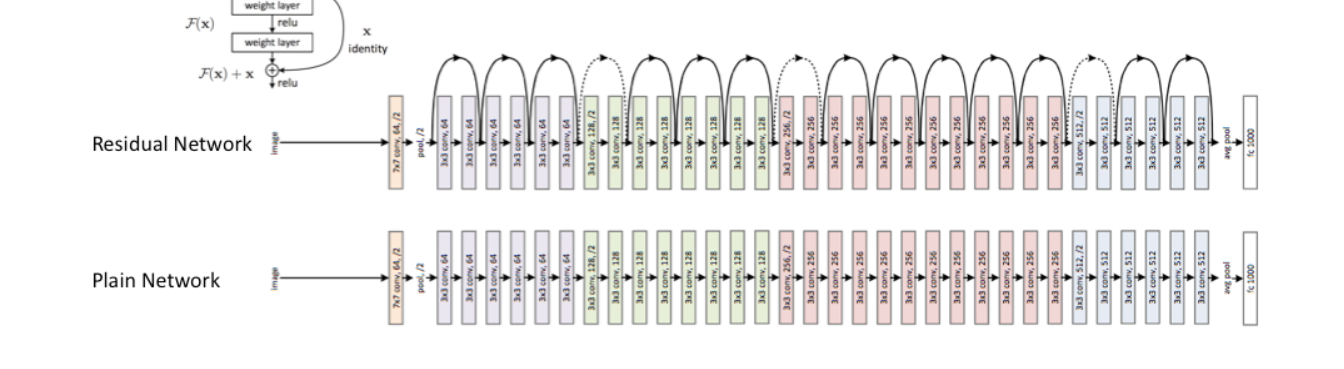

## Resnet 모델이란?
- residual block 을 이용하여 네트워크 최적화 난이도로 낮춘 모델이다.
- 기존에 학습한 X 는 그대로 가져오고 추가적으로 필요한 정보만 학슴한다, 그래서 학습 난이도를 낮춰준다.(shortcut connection)
----
layer 지나가는 과정

- convolution layer
- batch nomalization
- relu

## Resnet 모델의 형상 
- 34 layer, 50 layer 공통점
    - convolution block 이 3,4,6,3, 개씩 반복해서 쌓은 형태이다
- 차이점
    - block 안의 구성 형태가 다르다
    - 34 layer 의 경우 3x3 layer 로 구성
    - 50 layer 경우 1x1 convolution layer 앞뒤로 있다



## ✔ 목차
1. Resnet 34 구현
2. Resnet 50 구현
3. plain_34 구현
4. plain_50 구현
5. 학습
    - Resnet 34
    - Resnet 50
    - plain 34
    - plain 50 
6. 결과 비교

## 어떻게 모델을 구현할 것인가?(plan)
1. conv_block 만든다
    - convoltion
    - batch normalization
    - relu(activation)
2. bulid resnet block
3. build_resnet


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [13]:
def conv_block(input_layer, 
               channel, 
               kernel_size, 
               strides=1, 
               activation='relu'):
    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',
                            strides=strides
                           )(input_layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [14]:
def build_resnet_block(input_layer, 
                       num_cnn=3, 
                       channel=64, 
                       block_num=0, 
                       is_50=True):
    
    x = input_layer
    
    # ResNet-50
    if is_50:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # ResNet-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    

    return x

In [15]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=True, 
                 activation='softmax',
                 name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 Residual block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x, 
                               num_cnn=num_cnn, 
                               channel=channel, 
                               block_num=block_num, 
                               is_50=is_50)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation, 
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

## resnet_34

In [16]:
resnet_34 = build_resnet(input_shape=(32,32,3), is_50=False, name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 16, 16, 64)   9472        ['input_4[0][0]']                
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 16, 16, 64)  256         ['conv2d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_3 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_3[0

## resnet_50

In [17]:
resnet_50 = build_resnet(input_shape=(32,32,3), is_50=True, name='ResNet_50')
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_39 (Conv2D)             (None, 16, 16, 64)   9472        ['input_5[0][0]']                
                                                                                                  
 batch_normalization_39 (BatchN  (None, 16, 16, 64)  256         ['conv2d_39[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_36 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_39[

In [18]:
# resnet block에서 shortcut을 제외한 plain block
def build_plain_block(input_layer, 
                      num_cnn=3, 
                      channel=64, 
                      block_num=0, 
                      is_50=True):
    
    x = input_layer
    
    # plain-50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
    
    # plain-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))

    return x

In [19]:
def build_plainnet(input_shape=(32,32,3), 
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=10,
                   is_50=True, 
                   activation='softmax',
                   name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 plain block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(x, 
                              num_cnn=num_cnn, 
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

## plain_34

In [20]:
plain_34 = build_plainnet(input_shape=(224,224,3), is_50=False, name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_92 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_92 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_85 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_93 (Conv2D)          (None, 56, 56, 64)        369

## plain_50

In [21]:
plain_50 = build_plainnet(input_shape=(224,224,3), is_50=False, name='Plain_50')
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_125 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_125 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_118 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_126 (Conv2D)         (None, 56, 56, 64)        369

## data load

In [22]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    # 80:20 split
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete98HVE0/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [23]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [24]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [25]:
print(f'Train 이미지 개수 : {len(ds_train)}')
print(f'Test 이미지 개수 : {len(ds_test)}')

Train 이미지 개수 : 18610
Test 이미지 개수 : 4652


In [26]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [27]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

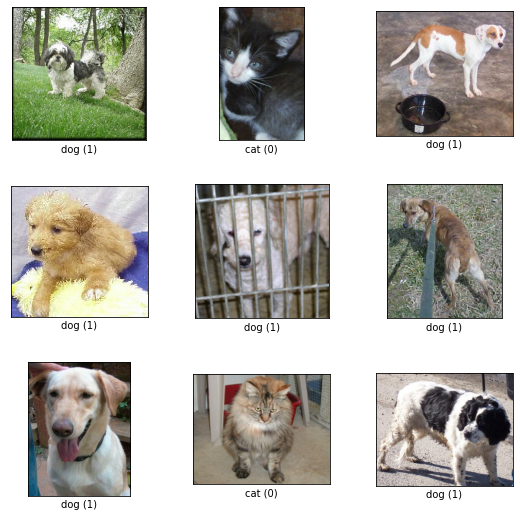

In [28]:
fig = tfds.show_examples(ds_train, ds_info)


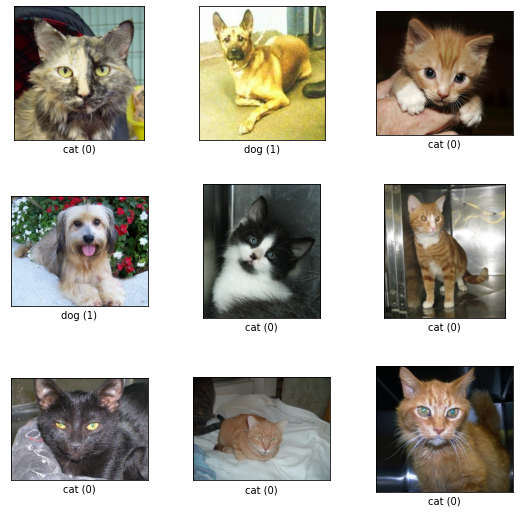

In [29]:
fig = tfds.show_examples(ds_test, ds_info)

## 학습시키기
- resnet_34
- resnet_40
- plain_34
- plain_50

In [30]:
BATCH_SIZE = 64
EPOCH = 20

In [31]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [32]:
model_resnet_34 = build_resnet(input_shape=(224, 224, 3),                                
                               num_classes=1, 
                               is_50=False, 
                               activation='sigmoid', 
                               name='ResNet_34')

In [33]:
model_resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_34 = model_resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


290/290 [==============================] - 99s 244ms/step - loss: 2.2663 - accuracy: 0.6436 - val_loss: 2.6966 - val_accuracy: 0.5508
Epoch 2/20
290/290 [==============================] - 66s 229ms/step - loss: 1.6607 - accuracy: 0.7490 - val_loss: 1.8546 - val_accuracy: 0.6322
Epoch 3/20
290/290 [==============================] - 67s 230ms/step - loss: 1.1891 - accuracy: 0.8129 - val_loss: 2.0782 - val_accuracy: 0.5664
Epoch 4/20
290/290 [==============================] - 67s 230ms/step - loss: 0.8537 - accuracy: 0.8638 - val_loss: 0.8580 - val_accuracy: 0.8243
Epoch 5/20
290/290 [==============================] - 67s 230ms/step - loss: 0.6537 - accuracy: 0.8891 - val_loss: 0.9985 - val_accuracy: 0.7252
Epoch 6/20
290/290 [==============================] - 67s 230ms/step - loss: 0.5230 - accuracy: 0.9096 - val_loss: 0.5472 - val_accuracy: 0.8751
Epoch 7/20
290/290 [==============================] - 67s 230ms/step - loss: 0.4552 - accuracy: 0.9181 - val_loss: 0.7325 - val_accuracy: 0.7

In [34]:
model_resnet_50 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=True,
                         activation='sigmoid')

In [35]:
model_resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_50 = model_resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


290/290 [==============================] - 69s 177ms/step - loss: 5.3498 - accuracy: 0.6447 - val_loss: 4.4844 - val_accuracy: 0.6197
Epoch 2/20
290/290 [==============================] - 50s 174ms/step - loss: 3.6265 - accuracy: 0.7308 - val_loss: 3.0421 - val_accuracy: 0.7113
Epoch 3/20
290/290 [==============================] - 50s 173ms/step - loss: 2.5137 - accuracy: 0.7796 - val_loss: 2.5058 - val_accuracy: 0.6044
Epoch 4/20
290/290 [==============================] - 50s 174ms/step - loss: 1.8457 - accuracy: 0.8301 - val_loss: 2.6889 - val_accuracy: 0.5445
Epoch 5/20
290/290 [==============================] - 50s 174ms/step - loss: 1.4275 - accuracy: 0.8665 - val_loss: 1.9400 - val_accuracy: 0.7607
Epoch 6/20
290/290 [==============================] - 50s 174ms/step - loss: 1.1715 - accuracy: 0.8879 - val_loss: 1.4762 - val_accuracy: 0.7365
Epoch 7/20
290/290 [==============================] - 50s 173ms/step - loss: 0.9921 - accuracy: 0.9073 - val_loss: 1.0990 - val_accuracy: 0.8

In [36]:
model_plain_34 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=False, 
                          activation='sigmoid',
                          name='Plain_34')

In [37]:
model_plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_34 = model_plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


290/290 [==============================] - 79s 221ms/step - loss: 1.8778 - accuracy: 0.5801 - val_loss: 1.5338 - val_accuracy: 0.5679
Epoch 2/20
290/290 [==============================] - 64s 220ms/step - loss: 1.3343 - accuracy: 0.6084 - val_loss: 9.7394 - val_accuracy: 0.5621
Epoch 3/20
290/290 [==============================] - 64s 220ms/step - loss: 1.1072 - accuracy: 0.6345 - val_loss: 1.3611 - val_accuracy: 0.5349
Epoch 4/20
290/290 [==============================] - 64s 221ms/step - loss: 0.9638 - accuracy: 0.6594 - val_loss: 1.1832 - val_accuracy: 0.5137
Epoch 5/20
290/290 [==============================] - 64s 222ms/step - loss: 0.8863 - accuracy: 0.6711 - val_loss: 0.9172 - val_accuracy: 0.6500
Epoch 6/20
290/290 [==============================] - 64s 220ms/step - loss: 0.8188 - accuracy: 0.6926 - val_loss: 0.9363 - val_accuracy: 0.5233
Epoch 7/20
290/290 [==============================] - 64s 221ms/step - loss: 0.7632 - accuracy: 0.7156 - val_loss: 0.8180 - val_accuracy: 0.6

In [38]:
model_plain_50 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=True,
                          activation='sigmoid')

In [39]:
model_plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_50 = model_plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


290/290 [==============================] - 108s 313ms/step - loss: 4.1294 - accuracy: 0.6010 - val_loss: 3.2342 - val_accuracy: 0.5171
Epoch 2/20
290/290 [==============================] - 90s 311ms/step - loss: 2.7096 - accuracy: 0.6321 - val_loss: 2.4485 - val_accuracy: 0.6265
Epoch 3/20
290/290 [==============================] - 90s 309ms/step - loss: 2.1441 - accuracy: 0.6334 - val_loss: 2.3002 - val_accuracy: 0.4324
Epoch 4/20
290/290 [==============================] - 90s 310ms/step - loss: 1.8485 - accuracy: 0.6361 - val_loss: 2.9457 - val_accuracy: 0.5185
Epoch 5/20
290/290 [==============================] - 90s 310ms/step - loss: 1.6250 - accuracy: 0.6727 - val_loss: 1.5683 - val_accuracy: 0.6526
Epoch 6/20
290/290 [==============================] - 90s 310ms/step - loss: 1.4329 - accuracy: 0.7108 - val_loss: 1.8295 - val_accuracy: 0.4874
Epoch 7/20
290/290 [==============================] - 90s 310ms/step - loss: 1.4258 - accuracy: 0.6560 - val_loss: 1.4660 - val_accuracy: 0.

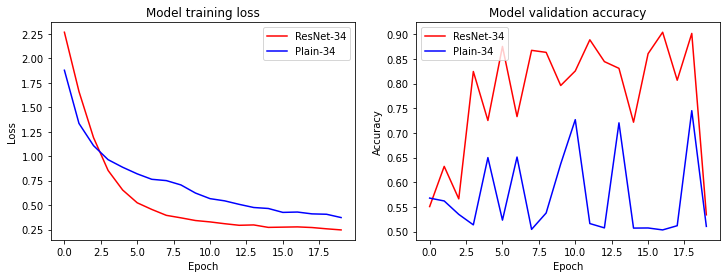

In [40]:
# ResNet-34 vs Plain-34
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')
plt.show()

- Resnet 34 모델이 plain 34 모델보다 loss 가 작다
- Resnet 34 모델이 plain 34 모델보다 accuracy 가 놓다

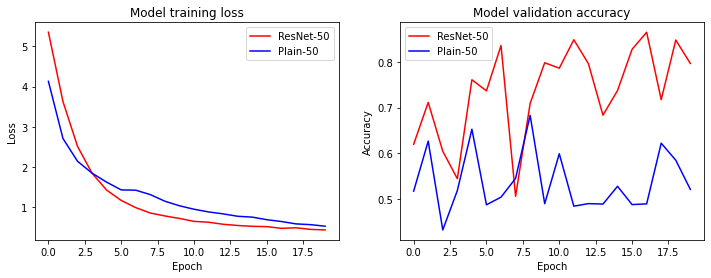

In [41]:
# ResNet-50 vs Plain-50
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper left')
plt.show()

- Resnet 50 모델이 plain 50 모델보다 전체적으로 좋은 특성을 보임을 확인할 수 있다.

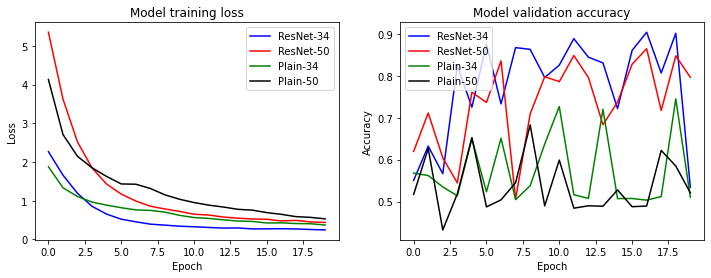

In [42]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34.history['loss'], 'b')
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'g')
plt.plot(history_plain_50.history['loss'], 'k')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34.history['val_accuracy'], 'b')
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'g')
plt.plot(history_plain_50.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper left')
plt.show()

accuracy 가 resnet 34 > resnet 50 > plain 34 > plain 50
- 깊게 쌓는다고 모델이 좋게 평가되는건 아니라는걸 알 수 있다.


## 회고
- 실제로 vgg, resnet 모델이 어떻게 구성되어있는지 공부하고 구현해보는 경험은 처음이었다. 너무 어려웠고 어떻게 코드를 짜야할지 막막한 부분이 많았다.
그래도 실제로 구현해보니 어떻게 구성되어있는지 명확하게 알게되는 점이 좋았다.점점 노드를 진행할 수록 부족한 부분이 많이 보여서 힘들다.
- 구글로 찾아서 다른사람들 코드 많이 참고하였다 ㅜㅜ
